In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



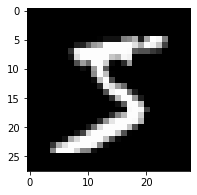

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

for i in range(0,1):
  img = np.squeeze(images[i])
  fig = plt.figure(figsize = (3,3)) 
  ax = fig.add_subplot(111)
  ax.imshow(img, cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)

        return out

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))

        return out

In [ ]:
input_size = 784
d_output_size = 1
d_hidden_size = 32

z_size = 100
g_output_size = 784
g_hidden_size = 32

In [ ]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
import torch.optim as optim

lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [ ]:
import pickle as pkl

num_epochs = 100

samples = []
losses = []

print_every = 400
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1
        
        
        d_optimizer.zero_grad()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)   
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))
    
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3995 | g_loss: 0.7204
Epoch [    1/  100] | d_loss: 0.6986 | g_loss: 6.4104
Epoch [    1/  100] | d_loss: 1.1772 | g_loss: 1.7509
Epoch [    2/  100] | d_loss: 1.7343 | g_loss: 1.2096
Epoch [    2/  100] | d_loss: 0.8866 | g_loss: 2.4031
Epoch [    2/  100] | d_loss: 1.1793 | g_loss: 1.3022
Epoch [    3/  100] | d_loss: 1.2412 | g_loss: 0.9082
Epoch [    3/  100] | d_loss: 1.2277 | g_loss: 0.9105
Epoch [    3/  100] | d_loss: 1.2573 | g_loss: 1.0137
Epoch [    4/  100] | d_loss: 1.2244 | g_loss: 1.3806
Epoch [    4/  100] | d_loss: 1.0910 | g_loss: 1.1852
Epoch [    4/  100] | d_loss: 0.9958 | g_loss: 1.2457
Epoch [    5/  100] | d_loss: 0.9822 | g_loss: 2.8558
Epoch [    5/  100] | d_loss: 1.2122 | g_loss: 1.0830
Epoch [    5/  100] | d_loss: 1.0829 | g_loss: 2.0885
Epoch [    6/  100] | d_loss: 1.2410 | g_loss: 1.0056
Epoch [    6/  100] | d_loss: 1.2736 | g_loss: 1.0175
Epoch [    6/  100] | d_loss: 1.3018 | g_loss: 1.4216
Epoch [    7/  100] | d_loss

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

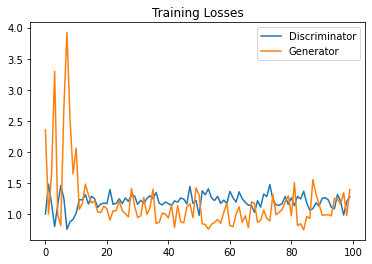

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

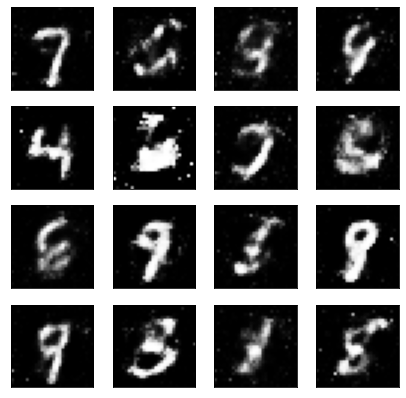

In [ ]:
view_samples(-1, samples)

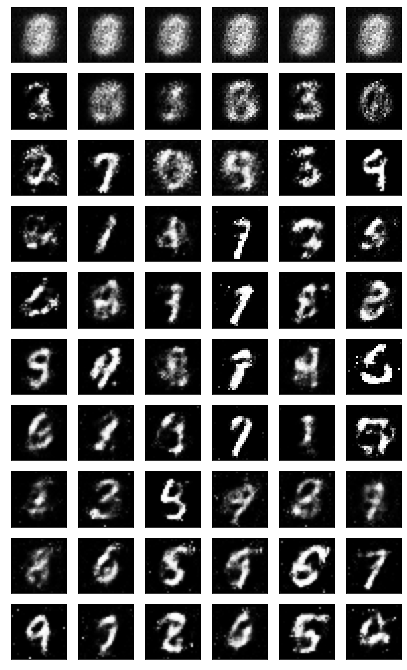

In [ ]:
rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


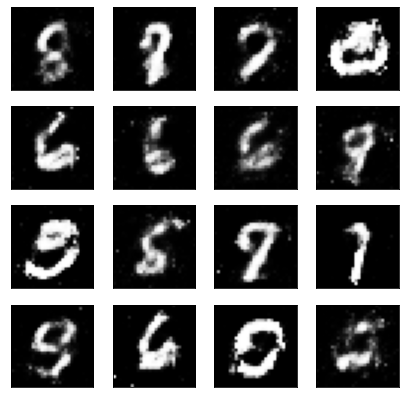

In [ ]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)
view_samples(0, [rand_images])